In [1]:
# %%
# Load packages
import os
import sklearn
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torcheval.metrics.functional import r2_score
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchsummary import summary

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
# Change CSV file
def change_csv_file(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    # Create 2 new columns
    df["camera_01"] = df.index.to_series().apply(lambda x: f"image_01_{x + 1}.jpg")
    df["camera_02"] = df.index.to_series().apply(lambda x: f"image_02_{x + 1}.jpg")
    # Save the new CSV file
    df.to_csv('data/rotations_w_images.csv', index=False)

change_csv_file("data/rotations.csv")

In [3]:
# Dataset
class WindTurbineDataset(Dataset):
    """
        Args:
            root_dir (string): Directory with csv and image folder.
            csv_file (string): Path to the csv file with filenames and angles
            image_folder (string): Directory with images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
    def __init__(self, csv_file, image_folder, root_dir, images_num=1, transform_size=None):
        self.root_dir = root_dir
        csv_path =  os.path.join(self.root_dir, csv_file)
        self.rotations_df = pd.read_csv(csv_path)
        self.transform_size = transform_size
        self.image_folder = []
        for i in range(images_num):
            self.image_folder.append(image_folder+f"_0{i+1}/")

    def __len__(self):
        return len(self.rotations_df)
    
    def _transform(self, transform_size, image):
    
        if transform_size.any() == None:
            #Get size of the image
            x,y = image.size
            transform = transforms.Compose([
            transforms.Resize((int(y),int(x))), # Resizing the image to 360x640
            transforms.ToTensor()
            ])
        else:
            transform = transforms.Compose([
            transforms.Resize((int(transform_size[0]),int(transform_size[1]))), # Resizing the image to 360x640
            transforms.ToTensor()
        ])
        return transform(image)


    def __getitem__(self, idx):
        # Get the image file path
        images = []
        for i in range(len(self.image_folder)):
            img_name = (os.path.join(self.root_dir, self.image_folder[i], self.rotations_df.iloc[idx, i+2])) #'filename' is the third column
            images.append(Image.open(img_name))
        base_angles = self.rotations_df.iloc[idx, 0] 
        blade_angles = self.rotations_df.iloc[idx, 1]
        angles = torch.tensor([base_angles, blade_angles], dtype=torch.float32)

        images = [self._transform(self.transform_size, image) for image in images]
        images = torch.concatenate(images, dim=0)  

        return images, angles

In [4]:
# Dataloader
class WindTurbineDataloader(Dataset):
    @staticmethod
    def train_test_split(dataset, test_size=0.2):
        # Split the dataset into training and testing sets
        train_size = int((1 - test_size) * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        # Seperate the labels from the features
        return train_dataset, test_dataset
    @staticmethod
    def dataloader(dataset, batch_size=64, shuffle=True):
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [5]:
#%%
# Neuralt Network
class CNN_Regressor_4(nn.Module):
    def __init__(self):
        super().__init__()

        # Original Image (720, 1280, 6) -> Downscaled by factor 4 -> Input image (180, 320, 6)
        
        self.convolution_stack = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 50, kernel_size = 9, stride = 3, bias = True), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels = 50, out_channels = 100, kernel_size = 7, stride = 3, bias = True), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=2), 
            nn.Conv2d(in_channels = 100, out_channels = 100, kernel_size = 5, stride = 3, bias = True), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels = 100, out_channels = 150, kernel_size = 5, stride =1, bias = True), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels = 150, out_channels = 200, kernel_size = 3, stride =2, bias = True), 
            nn.ReLU(),
        )
        
        self.linear_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 600, out_features = 200, bias = True),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features = 200, out_features = 128, bias = True),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features = 128, out_features = 32, bias = True),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features = 32, out_features = 8, bias = True),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features = 8, out_features = 2, bias = True),
        )
    
    def forward(self, x):
        conv_out = self.convolution_stack(x)
        fc_out = self.linear_stack(conv_out)
        return fc_out

model = CNN_Regressor_4().to(device)
summary(model, input_size = (6, 720, 1280), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 50, 238, 424]          24,350
              ReLU-2         [-1, 50, 238, 424]               0
           Dropout-3         [-1, 50, 238, 424]               0
            Conv2d-4         [-1, 100, 78, 140]         245,100
              ReLU-5         [-1, 100, 78, 140]               0
         MaxPool2d-6          [-1, 100, 36, 67]               0
            Conv2d-7          [-1, 100, 11, 21]         250,100
              ReLU-8          [-1, 100, 11, 21]               0
           Dropout-9          [-1, 100, 11, 21]               0
           Conv2d-10           [-1, 150, 7, 17]         375,150
             ReLU-11           [-1, 150, 7, 17]               0
        MaxPool2d-12            [-1, 150, 3, 8]               0
           Conv2d-13            [-1, 200, 1, 3]         270,200
             ReLU-14            [-1, 20

In [6]:
#%%
batch_size = 64
# Load data
wind_dataset = WindTurbineDataset(csv_file='rotations_w_images.csv', image_folder='camera', root_dir='data/', images_num=2, transform_size=np.array([720,1280])/1)
train_dataset, test_dataset = WindTurbineDataloader.train_test_split(wind_dataset, test_size=0.3)
trainloader = WindTurbineDataloader.dataloader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = WindTurbineDataloader.dataloader(test_dataset, batch_size=batch_size, shuffle=True)
# Load model
model = CNN_Regressor_4().to(device)
# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
#%%
# Training
class Trainer:
    train_loss = []
    test_loss = []

    def __init__(self, model, trainloader, testloader, criterion, optimizer, device, epochs=10):
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
    
    def _train(self, dataloader, model, criterion, optimizer, device):
        model.train()
        running_loss = 0.0

        for _, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs-0.5
            labels[:,0] = labels[:,0]/360
            labels[:,1] = labels[:,1]/120
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute the prediction error
            pred = model(inputs)
            loss = criterion(pred,labels)
            running_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        schedular.step()
        avg_loss = running_loss / len(dataloader)
        return avg_loss
    
    def _test(self, dataloader, model, criterion, device):
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for _, data in enumerate(dataloader):
                inputs, labels = data
                print(inputs.size())
                inputs = inputs-0.5
                labels[:,0] = labels[:,0]/360
                labels[:,1] = labels[:,1]/120
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the prediction error
                pred = model(inputs)
                loss = criterion(pred,labels)
                running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        return avg_loss
    
    def train_model(self):
        for epoch in range(self.epochs):
            train_loss = self._train(self.trainloader, self.model, self.criterion, self.optimizer, self.device)
            test_loss = self._test(self.testloader, self.model, self.criterion, self.device)
            self.train_loss.append(train_loss)
            self.test_loss.append(test_loss)
            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")


In [ ]:
#%%
trainer = Trainer(model, trainloader, testloader, criterion, optimizer, device, epochs=5)
trainer.train_model()
# Plot the training and testing loss
plt.plot(trainer.train_loss, label="Train Loss")
plt.plot(trainer.test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([64, 6, 720, 1280])


In [ ]:
model.eval()
running_loss = 0.0

with torch.no_grad():
    for _, data in enumerate(testloader):
        inputs, labels = data
        inputs_n = inputs-0.5
        labels[:,0] = labels[:,0]/360
        labels[:,1] = labels[:,1]/120
        inputs_n, labels_n = inputs_n.to(device), labels.to(device)

        # Compute the prediction error
        pred = model(inputs_n)
        loss = criterion(pred,labels_n)
        running_loss += loss.item()
avg_loss = running_loss / len(testloader)

[135.04541 135.04541 135.04541 135.04541]


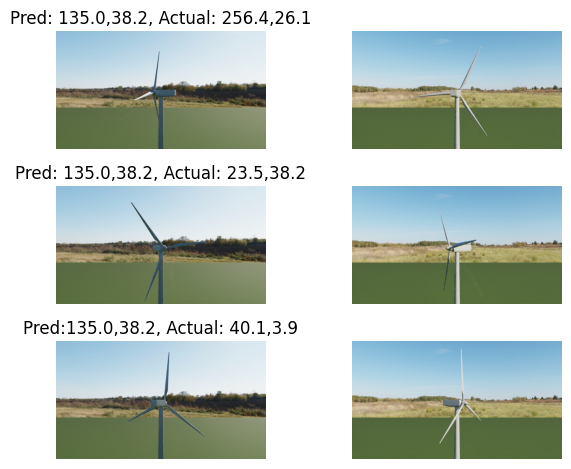

In [ ]:
im1 = inputs[:,0:3,:,:]
im1 = torch.permute(im1,(0,2,3,1)).numpy()
im2 = inputs[:,3:6,:,:]
im2 = torch.permute(im2,(0,2,3,1)).numpy()
preds = torch.Tensor.cpu(pred).numpy()
rot_base = labels[:,0]*360
rot_wings = labels[:,1]*120
pred_base = preds[:,0]*360
pred_wings = preds[:,1]*120
print(pred_base)

ax = plt.subplot(3,2,1)
ax.imshow(im1[0,:,:,:])
ax.set_axis_off()
ax.set_title(f"Pred: {pred_base[0]:.1f},{pred_wings[0]:.1f}, Actual: {rot_base[0]:.1f},{rot_wings[0]:.1f}")

ax = plt.subplot(3,2,2)
ax.imshow(im2[0,:,:,:])
ax.set_axis_off()

ax = plt.subplot(3,2,3)
ax.imshow(im1[1,:,:,:])
ax.set_axis_off()
ax.set_title(f"Pred: {pred_base[1]:.1f},{pred_wings[1]:.1f}, Actual: {rot_base[1]:.1f},{rot_wings[1]:.1f}")

ax = plt.subplot(3,2,4)
ax.imshow(im2[1,:,:,:])
ax.set_axis_off()

ax = plt.subplot(3,2,5)
ax.imshow(im1[2,:,:,:])
ax.set_axis_off()
ax.set_title(f"Pred:{pred_base[2]:.1f},{pred_wings[2]:.1f}, Actual: {rot_base[2]:.1f},{rot_wings[2]:.1f}")

ax = plt.subplot(3,2,6)
ax.imshow(im2[2,:,:,:])
ax.set_axis_off()

plt.tight_layout()
